In [2]:
import os
print(os.getcwd())
import pandas as pd
import os
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords 
import string
import numpy as np
from numpy import array
import argparse
from wordcloud import WordCloud, ImageColorGenerator, STOPWORDS

import matplotlib.pyplot as plt

from keras.preprocessing.text import Tokenizer
# from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from keras_preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import GRU, Embedding, Conv1D, MaxPooling1D, Dropout, Dense, Flatten, LSTM, SpatialDropout1D
from keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping

import tensorflow as tf

nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('omw-1.4')

print('Working directory: ', os.getcwd())

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

tf.test.gpu_device_name()

/home/nguyen/Desktop/learning-nlp/news_sentiment


ImportError: cannot import name 'pad_sequences' from 'keras.preprocessing.sequence' (/home/nguyen/Desktop/learning-nlp/.env/lib/python3.8/site-packages/keras/preprocessing/sequence.py)

In [ ]:
DATASET = './datasets/all-data.csv'
CSV_ENCODING = 'ISO-8859-1'

In [ ]:
df = pd.read_csv(DATASET, encoding=CSV_ENCODING, header=None)
df.columns = ['label', 'text']
df.head()

,label,text
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...


DESCRIBE:
########
          label                                               text
count      4846                                               4846
unique        3                                               4838
top     neutral  TELECOMWORLDWIRE-7 April 2006-TJ Group Plc sel...
freq       2879                                                  2
CHECK NULL: 
 label    0
text     0
dtype: int64
########


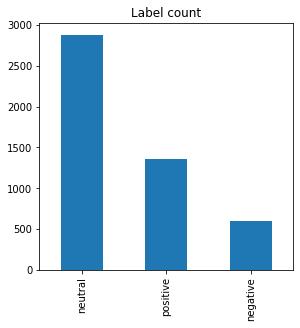

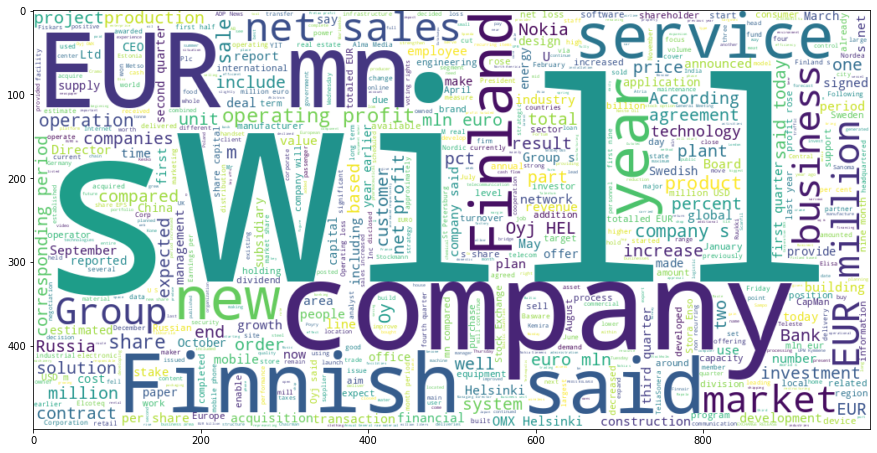

In [ ]:
print("DESCRIBE:")
print("########")
print(df.describe())
print('CHECK NULL: \n', df.isnull().sum())
print("########")
plt.subplot(221)
df['label'].value_counts().plot(kind="bar", title="Label count", figsize = (10,10))
plt.show()

combined_text = ''

for index, row in df.iterrows():
    combined_text += row['text']


wc = WordCloud(max_words = 1500, stopwords = STOPWORDS, background_color= 'white', width = 1000, height=500).generate(combined_text)
plt.figure(figsize=(15,15))
plt.imshow(wc, interpolation='bilinear')
plt.savefig('wordcloud.png')
plt.show()

In [ ]:
sample_text = list()
sample_text.append(df['text'][0])
sample_text.append(df['text'][10])
sample_text.append(df['text'][100])
sample_text.append(df['text'][1000])

for text in sample_text:
    print(text)
    print("\n")

According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .


TeliaSonera TLSN said the offer is in line with its strategy to increase its ownership in core business holdings and would strengthen Eesti Telekom 's offering to its customers .


Both operating profit and turnover for the three-month period increased , respectively from EUR0 .9 m and EUR8 .3 m , as compared to the corresponding period in 2005 .


Incap Corporation Stock Exchange Release 4 May 2010 at 8.30 a.m. INCAP CORPORATION 'S DIRECTED SHARE ISSUE WAS SUBSCRIBED IN FULL The Board of Incap Corporation has approved the subscriptions of directed share issue .




### Clean the doc

In [ ]:
def clean_text(text):
    text = text.lower()
    table = str.maketrans("", '', string.punctuation)
    text = text.translate(table)

    # stop_words = stopwords.words('english')
    # porter = PorterStemmer()
    text = text.lower()
    tokens = text.split(" ")

    # tokens = [word for word in tokens if word.isalpha()]

    return tokens

processed_df = df.copy(deep=True)

processed_df['text'] = processed_df['text'].apply(clean_text)

print(processed_df.head())

print(df['text'][0])
print(processed_df['text'][0])


      label                                               text
0   neutral  [according, to, gran, , the, company, has, no,...
1   neutral  [technopolis, plans, to, develop, in, stages, ...
2  negative  [the, international, electronic, industry, com...
3  positive  [with, the, new, production, plant, the, compa...
4  positive  [according, to, the, company, s, updated, stra...
According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .
['according', 'to', 'gran', '', 'the', 'company', 'has', 'no', 'plans', 'to', 'move', 'all', 'production', 'to', 'russia', '', 'although', 'that', 'is', 'where', 'the', 'company', 'is', 'growing', '']


### Building Vocab from dataset

In [ ]:
def process_features(features, labels, tokenizer, maxlen, is_train = True):
    if is_train:
        tokenizer.fit_on_texts(features)
    encoded_dataset = tokenizer.texts_to_sequences(features)

    #pad sequences to the max length sequence
    x_train = pad_sequences(encoded_dataset, maxlen=maxlen, padding="post")
    y_train = array(labels)
    return x_train, y_train

def load_embedding(filename, is_glove = False):
    embedding = dict() 
    with open(filename) as file:
        if is_glove:
            lines = file.readlines()#glove format doesn't have header file so take all lines
        else:
            lines = file.readlines()[1:]# ignore the first line, which is 25435, 100 ( vocab_size, vector_size)
        for line in lines:
            parts = line.split(" ")
            embedding[parts[0]] = array(parts[1:], dtype='float32')
    return embedding

def embedding_to_weight_matrix(embedding, vocab, vector_size = 100):

    # vocab size + 0 for unknown words
    vocab_size = len(vocab) + 1 

    matrix = np.zeros((vocab_size, vector_size)) 

    for word, index in vocab.items():
        vector = embedding.get(word)
        if vector is not None:
            matrix[index] = vector 

    return matrix

In [ ]:
# build vocab
docs = list() 
labels = list()
for index, row in processed_df.iterrows():
    docs.append(row['text'])
    labels.append(row['label'])

maxlen_token = max([len(doc) for doc in docs])
tokenizer = Tokenizer()

X, y = process_features(docs, labels, tokenizer, maxlen_token)
binarizer = LabelBinarizer()
y = binarizer.fit_transform(labels)

vocab_path = 'vocab.txt'

if os.path.exists(vocab_path) == False:
    vocab = tokenizer.word_index
    to_write = list()
    for key, value in vocab.items():
        to_write.append("{}:{}".format(key, value))

    with open(vocab_path, 'w') as file:
        file.write("\n".join(to_write))
else:
    with open(vocab_path, 'r') as file:
        vocab = dict()
        lines = file.readlines()
        for line in lines:
            (key, value) = line.split(":")
            vocab[key] = int(value.strip())

print("Max len token = ", maxlen_token)
print("Vocab len = ", len(vocab))
print("x_train shape: ", X.shape)
print("y_train shape: ", y.shape)
print("x_train sample: ", X[0])
print("y_train sample: ", y[0])
print("label classes :", binarizer.classes_)


Max len token =  81
Vocab len =  11255
x_train shape:  (4846, 81)
y_train shape:  (4846, 3)
x_train sample:  [  80    6 3548    1    2   13   17  221  302    6  619  112   74    6
  128    1 2798   29   11  391    2   13   11  708    1    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0]
y_train sample:  [0 1 0]
label classes : ['negative' 'neutral' 'positive']


In [ ]:
embedding = load_embedding('./datasets/glove.6B/glove.6B.100d.txt', True)
weight_matrix = embedding_to_weight_matrix(embedding, vocab)
print(weight_matrix)

[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [-0.038194   -0.24487001  0.72812003 ... -0.1459      0.82779998
   0.27061999]
 ...
 [ 0.94665998  0.37720999  0.42651001 ...  0.12631001 -0.39664
  -0.82271999]
 [ 0.064426    0.11901    -0.14339    ...  0.09702    -0.011537
  -0.26341999]
 [ 0.11716    -0.13082001 -0.30669001 ...  0.11641    -0.46175
   0.21679001]]


In [ ]:
def summarize_diagnostic(history, path = '', description = None):
    plt.figure(figsize=(10,10))
    plt.figtext(0, 1, description, fontsize=15)
    plt.subplot(211)
    plt.title("Loss")
    plt.plot(history.history['loss'], color="blue", label="train loss")
    plt.plot(history.history['val_loss'], color="red", label="validation loss")
    plt.legend()
    plt.subplot(212)
    plt.title("Accuracy")
    plt.plot(history.history['accuracy'], color="blue", label="train accuracy")
    plt.plot(history.history['val_accuracy'], color="red", label="validation accuracy")
    plt.legend()
    if(path!= ''):
        plt.rcParams['savefig.facecolor'] = 'white'
        plt.savefig(path, dpi = 100, bbox_inches = 'tight')

def base_model(args):
    
    model = Sequential()
    model.add(Embedding(args.vocab_size + 1, 100, input_length=args.maxlen_token))
    model.add(GRU(256, return_sequences=True, activation='tanh'))
    model.add(Flatten())
    model.add(Dense(3, activation='softmax'))
    return model
    # model.add(Conv1D(filters=16, kernel_size = 5, activation='relu'))
    # model.add(MaxPooling1D(2))
    # model.add(Dropout(0.2))
    # model.add(Flatten())
    # model.add(Dense(3, activation='sigmoid'))

    return model

def base_lstm(args):
    model = Sequential()
    model.add(Embedding(args.vocab_size + 1, 100, embeddings_initializer='he_uniform', input_length=args.maxlen_token))
    model.add(SpatialDropout1D(0.4))
    model.add(LSTM(196, dropout=0.2, recurrent_dropout=0.2))
    # model.add(Flatten())
    # model.add(Dense(100, activation='relu'))
    model.add(Dense(3, activation='softmax'))

    return model

def glove_model(args, weight_matrix):
    model = Sequential()
    model.add(Embedding(args.vocab_size + 1, 100, weights=[weight_matrix], input_length=args.maxlen_token, trainable = False))
    model.add(Dropout(0.2))
    model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(3, activation='sigmoid'))

    return model

def compile_model(model, args):
    model.compile(loss='categorical_crossentropy', 
    optimizer = Adam(learning_rate = args.learning_rate),
     metrics=['accuracy'])
    return model

def train(model, args, checkpoint = True, checkpoint_path = None):
    if checkpoint:
        if checkpoint_path == None:
            checkpoint_path = './tmp/checkpoint'
    
        if os.path.exists(checkpoint_path):
            print("Loaded weight checkpoint in {}".format(checkpoint_path))
            model.load_weights(checkpoint_path)
    
    model_checkpoint = ModelCheckpoint(
        filepath = checkpoint_path,
        save_weights_only=True,
        monitor = 'val_accuracy',
        mode = 'max',
        save_best_only= True
    )

    early_stopping = EarlyStopping(
        monitor='val_accuracy',
        patience=3,
        restore_best_weights=True
    )

    if checkpoint:
        return model.fit(
            args.X,
            args.y,
            epochs = args.epochs,
            verbose = args.verbose,
            validation_split = args.validation_split,
            callbacks = [model_checkpoint, early_stopping],
        )
    else:
        return model.fit(
            args.X,
            args.y,
            epochs = args.epochs,
            verbose = args.verbose,
            validation_split = args.validation_split,
            callbacks = [early_stopping],
        )

In [ ]:
args = argparse.Namespace()

args.epochs = 10
args.verbose = 1
args.loss = 'categorical_crossentropy'
args.maxlen_token = maxlen_token
args.learning_rate = 1e-3
args.vocab_size = len(vocab)
args.X = X 
args.y = y 
args.validation_split = 0.4

In [ ]:
# model = glove_model(args, weight_matrix)

model = base_model(args)
model.summary()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 81, 100)           1125600   
                                                                 
 gru_5 (GRU)                 (None, 81, 256)           274944    
                                                                 
 flatten_6 (Flatten)         (None, 20736)             0         
                                                                 
 dense_6 (Dense)             (None, 3)                 62211     
                                                                 
Total params: 1,462,755
Trainable params: 1,462,755
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# model = compile_model(model, args)
history = train(model, args, checkpoint= False)

Epoch 1/10
91/91 [==============================] - 2s 9ms/step - loss: 0.7420 - accuracy: 0.6292 - val_loss: 1.0667 - val_accuracy: 0.6019
Epoch 2/10
91/91 [==============================] - 1s 6ms/step - loss: 0.3999 - accuracy: 0.8514 - val_loss: 1.1378 - val_accuracy: 0.5941
Epoch 3/10
91/91 [==============================] - 1s 6ms/step - loss: 0.1403 - accuracy: 0.9463 - val_loss: 1.4151 - val_accuracy: 0.6230
Epoch 4/10
91/91 [==============================] - 1s 6ms/step - loss: 0.0499 - accuracy: 0.9859 - val_loss: 1.7557 - val_accuracy: 0.5673
Epoch 5/10
91/91 [==============================] - 1s 6ms/step - loss: 0.0288 - accuracy: 0.9945 - val_loss: 2.0731 - val_accuracy: 0.5699
Epoch 6/10
91/91 [==============================] - 1s 6ms/step - loss: 0.0204 - accuracy: 0.9962 - val_loss: 1.6899 - val_accuracy: 0.6204


    RESULTS:    model config: VGG16_trainable
    learning_rate: 0.001
    epochs: 10
    valid_accuracy: 0.640536367893219
    valid_loss: 1.1425327062606812



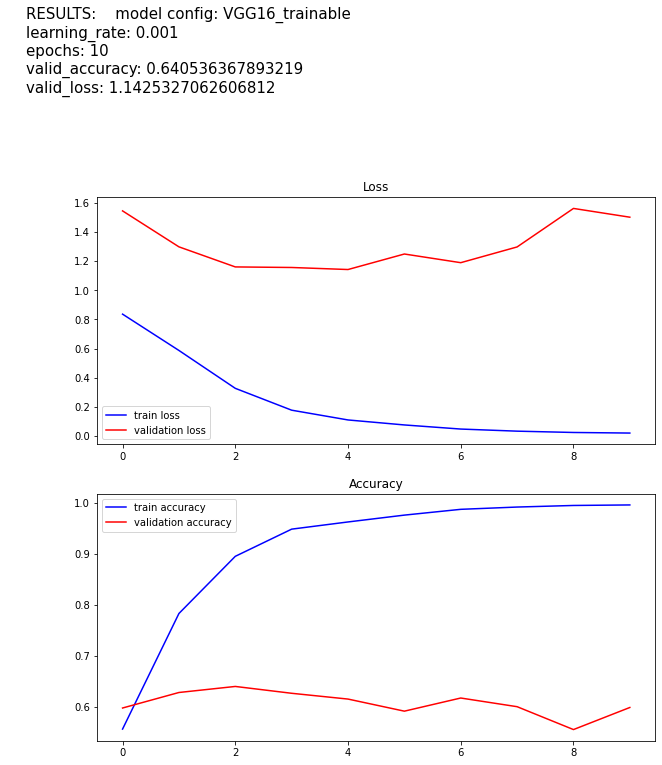

In [ ]:

description_text = "\
    RESULTS:\
    model config: {}\n\
    learning_rate: {}\n\
    epochs: {}\n\
    valid_accuracy: {}\n\
    valid_loss: {}\n".format(
    "VGG16_trainable", 
    args.learning_rate, 
    args.epochs,
    np.max(history.history['val_accuracy']),
    np.min(history.history['val_loss'])
    )

print(description_text)

summarize_diagnostic(history, 'base_model.png', description_text)